## <font color='cornflowerblue'> Packages

In [1]:
import ta
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

## <font color='cornflowerblue'> Classes and Functions

In [2]:
from dataclasses import dataclass

@dataclass
class Position:
    """ A cool representation of a position
    """
    ticker: str
    n_shares: int
    price: float
    sl: float
    tp: float
    time: str

In [3]:
class TradingMetrics:
    def __init__(self, portfolio_values: list[float], time_frame: int):
        self.portfolio_values = portfolio_values
        self.time_frame = time_frame  # in minutes

        self.df = pd.DataFrame({
            'value': self.portfolio_values,
            'rets': pd.Series(self.portfolio_values).pct_change()
        }).dropna()

    def sharpe_ratio(self) -> float:
        mean = self.df.rets.mean()
        std = self.df.rets.std()

        # 252 trading days, 6.5 hours per day, time_frame-min bars
        bars_per_year = (60 / self.time_frame) * 6.5 * 252
        annual_mean = mean * bars_per_year
        annual_std = std * np.sqrt(bars_per_year)
        
        return annual_mean / annual_std if annual_std != 0 else 0.0

    def sortino_ratio(self) -> float:
        mean = self.df.rets.mean()
        downside_risk = np.minimum(self.df.rets, 0).std()

        # 252 trading days, 6.5 hours per day, time_frame-min bars
        bars_per_year = (60 / self.time_frame) * 6.5 * 252
        annual_mean = mean * bars_per_year
        annual_downside_risk = downside_risk * np.sqrt(bars_per_year)

        return annual_mean / annual_downside_risk if annual_downside_risk != 0 else 0.0

    def max_drawdown(self) -> float:
        roll_max = self.df.value.cummax()
        drawdown = (roll_max - self.df.value) / roll_max  # Drawdown as positive values
        return drawdown.max()  # Maximum drawdown as positive percentage

    def calmar_ratio(self) -> float:
        mean = self.df.rets.mean()
        
        # 252 trading days, 6.5 hours per day, time_frame-min bars
        bars_per_year = (60 / self.time_frame) * 6.5 * 252
        annual_mean = mean * bars_per_year
        
        max_dd = self.max_drawdown()  # Now this returns a positive value
        
        return annual_mean / max_dd if max_dd != 0 else 0.0

    def show_metrics(self) -> pd.DataFrame:
        df = pd.DataFrame(
            {
                'Metric': ['Sharpe Ratio', 'Sortino Ratio', 'Max Drawdown', 'Calmar Ratio'],
                'Value': [self.sharpe_ratio(), self.sortino_ratio(), f'{self.max_drawdown():.2%}', self.calmar_ratio()]
            }
        )
        return df

In [4]:
def rsi(data: pd.DataFrame, window: int, rsi_lower: int, rsi_upper: int) -> pd.DataFrame:
    df = data.copy()
    rsi_indicator = ta.momentum.RSIIndicator(df.Close, window=window)
    df['rsi'] = rsi_indicator.rsi()
    df['buy_signal'] = df['rsi'] < rsi_lower
    df['sell_signal'] = df['rsi'] > rsi_upper
    df = df.dropna()
    return df

In [5]:
def get_portfolio_value(cash: float, long_ops: list[Position], short_ops: list[Position], current_price: float, 
                        n_shares: int, COM: float) -> float:
    
    val = cash 

    # Longs
    val += len(long_ops) * current_price * n_shares * (1 - COM)

    # Shorts
    short_val = sum(
        (pos.price - current_price) * pos.n_shares * (1 - COM)
        for pos in short_ops
    )

    return val + short_val

## <font color='cornflowerblue'> Data

In [6]:
data = pd.read_csv('Binance_BTCUSDT_1h.csv').dropna()
data

,Unix,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USDT,tradecount
0,1.758580e+12,22/09/25 23:00,BTCUSDT,112643.25,112739.14,112592.20,112650.99,135.310950,1.524494e+07,34083
1,1.758580e+12,22/09/25 22:00,BTCUSDT,112969.99,112970.00,112594.33,112643.25,289.607150,3.264691e+07,42836
2,1.758570e+12,22/09/25 21:00,BTCUSDT,112781.87,112970.00,112602.79,112969.99,293.311560,3.307493e+07,42931
3,1.758570e+12,22/09/25 20:00,BTCUSDT,112122.90,112977.41,111975.28,112781.88,596.840050,6.707508e+07,93553
4,1.758570e+12,22/09/25 19:00,BTCUSDT,112429.12,112600.87,111936.40,112122.90,1307.373650,1.467768e+08,126232
...,...,...,...,...,...,...,...,...,...,...
70822,1.502960e+12,17/08/17 8:00,BTCUSDT,4333.32,4377.85,4333.32,4360.69,0.972807,4.239504e+03,28
70823,1.502950e+12,17/08/17 7:00,BTCUSDT,4316.62,4349.99,4287.41,4349.99,4.443249,1.924106e+04,25
70824,1.502950e+12,17/08/17 6:00,BTCUSDT,4330.29,4345.45,4309.37,4324.35,7.229691,3.128231e+04,36
70825,1.502950e+12,17/08/17 5:00,BTCUSDT,4308.83,4328.69,4291.37,4315.32,23.234916,1.003048e+05,102


In [7]:
# Find columns containing "Date"
date_cols = [col for col in data.columns if "Date" in col]

# Rename them to "Datetime"
for col in date_cols:
    data = data.rename(columns={col: "Datetime"})

data["Datetime"] = pd.to_datetime(data["Datetime"], errors="coerce", dayfirst=True)

if data.Datetime.iloc[0] > data.Datetime.iloc[-1]:
    data = data.iloc[::-1]
    data = data.reset_index(drop=True)

/var/folders/60/rl4yk8jj3453bx7hbt074rbc0000gn/T/ipykernel_66508/584127041.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["Datetime"] = pd.to_datetime(data["Datetime"], errors="coerce", dayfirst=True)


In [8]:
data

,Unix,Datetime,Symbol,Open,High,Low,Close,Volume BTC,Volume USDT,tradecount
0,1.502940e+12,2017-08-17 04:00:00,BTCUSDT,4261.48,4313.62,4261.32,4308.83,47.181009,2.023661e+05,171
1,1.502950e+12,2017-08-17 05:00:00,BTCUSDT,4308.83,4328.69,4291.37,4315.32,23.234916,1.003048e+05,102
2,1.502950e+12,2017-08-17 06:00:00,BTCUSDT,4330.29,4345.45,4309.37,4324.35,7.229691,3.128231e+04,36
3,1.502950e+12,2017-08-17 07:00:00,BTCUSDT,4316.62,4349.99,4287.41,4349.99,4.443249,1.924106e+04,25
4,1.502960e+12,2017-08-17 08:00:00,BTCUSDT,4333.32,4377.85,4333.32,4360.69,0.972807,4.239504e+03,28
...,...,...,...,...,...,...,...,...,...,...
70822,1.758570e+12,2025-09-22 19:00:00,BTCUSDT,112429.12,112600.87,111936.40,112122.90,1307.373650,1.467768e+08,126232
70823,1.758570e+12,2025-09-22 20:00:00,BTCUSDT,112122.90,112977.41,111975.28,112781.88,596.840050,6.707508e+07,93553
70824,1.758570e+12,2025-09-22 21:00:00,BTCUSDT,112781.87,112970.00,112602.79,112969.99,293.311560,3.307493e+07,42931
70825,1.758580e+12,2025-09-22 22:00:00,BTCUSDT,112969.99,112970.00,112594.33,112643.25,289.607150,3.264691e+07,42836


In [9]:
train_size = int(len(data) * 0.6)
test_size = int(len(data) * 0.2)

In [10]:
train = data[:train_size]
test = data[train_size:train_size + test_size]
validation = data[train_size + test_size:]

In [11]:
train

,Unix,Datetime,Symbol,Open,High,Low,Close,Volume BTC,Volume USDT,tradecount
0,1.502940e+12,2017-08-17 04:00:00,BTCUSDT,4261.48,4313.62,4261.32,4308.83,47.181009,2.023661e+05,171
1,1.502950e+12,2017-08-17 05:00:00,BTCUSDT,4308.83,4328.69,4291.37,4315.32,23.234916,1.003048e+05,102
2,1.502950e+12,2017-08-17 06:00:00,BTCUSDT,4330.29,4345.45,4309.37,4324.35,7.229691,3.128231e+04,36
3,1.502950e+12,2017-08-17 07:00:00,BTCUSDT,4316.62,4349.99,4287.41,4349.99,4.443249,1.924106e+04,25
4,1.502960e+12,2017-08-17 08:00:00,BTCUSDT,4333.32,4377.85,4333.32,4360.69,0.972807,4.239504e+03,28
...,...,...,...,...,...,...,...,...,...,...
42491,1.656360e+12,2022-06-27 21:00:00,BTCUSDT,20913.57,20916.90,20783.15,20803.24,1093.614420,2.281656e+07,26735
42492,1.656370e+12,2022-06-27 22:00:00,BTCUSDT,20803.25,20950.00,20762.80,20814.42,2552.767290,5.323287e+07,41271
42493,1.656370e+12,2022-06-27 23:00:00,BTCUSDT,20814.42,20887.99,20680.00,20742.56,1915.178700,3.980011e+07,31550
42494,1.656370e+12,2022-06-28 00:00:00,BTCUSDT,20742.57,20873.82,20684.00,20770.50,2620.370960,5.444156e+07,40482


In [12]:
test

,Unix,Datetime,Symbol,Open,High,Low,Close,Volume BTC,Volume USDT,tradecount
42496,1.656380e+12,2022-06-28 02:00:00,BTCUSDT,20619.44,20684.39,20510.00,20640.98,3109.11374,64045339.30,47511
42497,1.656390e+12,2022-06-28 03:00:00,BTCUSDT,20640.99,20758.16,20630.98,20735.03,1658.46245,34318757.95,30968
42498,1.656390e+12,2022-06-28 04:00:00,BTCUSDT,20735.03,20795.09,20703.30,20771.57,1386.02065,28761410.08,25449
42499,1.656390e+12,2022-06-28 05:00:00,BTCUSDT,20771.58,20829.10,20735.42,20741.30,1466.51374,30479544.85,25900
42500,1.656400e+12,2022-06-28 06:00:00,BTCUSDT,20741.29,20900.00,20741.29,20862.65,1860.47094,38779664.51,35015
...,...,...,...,...,...,...,...,...,...,...
56656,1.707360e+12,2024-02-08 03:00:00,BTCUSDT,44648.33,44727.42,44534.00,44540.99,1587.88976,70876812.50,52995
56657,1.707360e+12,2024-02-08 04:00:00,BTCUSDT,44540.98,44605.00,44480.53,44489.90,806.92713,35947314.68,43600
56658,1.707370e+12,2024-02-08 05:00:00,BTCUSDT,44489.89,44633.78,44489.89,44552.90,1056.72544,47095692.12,42373
56659,1.707370e+12,2024-02-08 06:00:00,BTCUSDT,44552.89,44576.00,44450.00,44463.99,805.47228,35850869.77,49836


In [13]:
validation

,Unix,Datetime,Symbol,Open,High,Low,Close,Volume BTC,Volume USDT,tradecount
56661,1.707380e+12,2024-02-08 08:00:00,BTCUSDT,44513.25,44744.00,44513.24,44718.33,1350.57478,6.031290e+07,55669
56662,1.707380e+12,2024-02-08 09:00:00,BTCUSDT,44718.33,44788.01,44612.66,44692.81,1179.72665,5.273086e+07,60984
56663,1.707390e+12,2024-02-08 10:00:00,BTCUSDT,44692.82,44850.00,44686.61,44828.27,1663.73936,7.451093e+07,79476
56664,1.707390e+12,2024-02-08 11:00:00,BTCUSDT,44828.26,44885.00,44685.89,44698.97,1664.23633,7.454380e+07,90646
56665,1.707390e+12,2024-02-08 12:00:00,BTCUSDT,44698.97,44841.10,44606.00,44689.20,1322.97171,5.917232e+07,53368
...,...,...,...,...,...,...,...,...,...,...
70822,1.758570e+12,2025-09-22 19:00:00,BTCUSDT,112429.12,112600.87,111936.40,112122.90,1307.37365,1.467768e+08,126232
70823,1.758570e+12,2025-09-22 20:00:00,BTCUSDT,112122.90,112977.41,111975.28,112781.88,596.84005,6.707508e+07,93553
70824,1.758570e+12,2025-09-22 21:00:00,BTCUSDT,112781.87,112970.00,112602.79,112969.99,293.31156,3.307493e+07,42931
70825,1.758580e+12,2025-09-22 22:00:00,BTCUSDT,112969.99,112970.00,112594.33,112643.25,289.60715,3.264691e+07,42836


In [14]:
len(train), len(test), len(validation)

(42496, 14165, 14166)

In [15]:
data = pd.read_csv('aapl_5m_train.csv').dropna()

In [16]:
train = rsi(train, window=25, rsi_lower=32, rsi_upper=72)
train.head()

,Unix,Datetime,Symbol,Open,High,Low,Close,Volume BTC,Volume USDT,tradecount,rsi,buy_signal,sell_signal
24,1.503030e+12,2017-08-18 04:00:00,BTCUSDT,4292.39,4292.39,4234.43,4287.92,50.797515,216512.6330,267,45.947008,False,False
25,1.503030e+12,2017-08-18 05:00:00,BTCUSDT,4287.92,4340.62,4250.04,4313.56,64.169286,275592.0487,367,48.876334,False,False
26,1.503040e+12,2017-08-18 06:00:00,BTCUSDT,4313.56,4316.98,4247.75,4279.46,64.235424,275244.6022,298,45.463056,False,False
27,1.503040e+12,2017-08-18 07:00:00,BTCUSDT,4279.46,4304.67,4270.48,4300.25,69.186804,296605.4422,203,47.779097,False,False
28,1.503040e+12,2017-08-18 08:00:00,BTCUSDT,4285.00,4320.71,4259.85,4282.73,74.829849,321236.5948,247,46.061955,False,False


## <font color='cornflowerblue'> Parameters

In [17]:
COM: float = 0.125 / 100
BORROW_RATE: float = 0.25 / 100
INITIAL_MARGIN = 1.5
MAINTENANCE_MARGIN = 0.25

# Convert annualized borrow rate to 5-min bar rate
bars_per_year = 252 * 6.5 * 60 / 5  # 252 trading days, 6.5 hours per day, 5-min bars
bar_borrow_rate = BORROW_RATE / bars_per_year

# DOF
STOP_LOSS: float = 0.1
TAKE_PROFIT: float = 0.1
N_SHARES: int = 50

## <font color='cornflowerblue'> Backtest

In [18]:
capital: float = 1_000_000

portfolio_value = []
active_long_positions: list[Position] = []
active_short_positions: list[Position] = []

for i, row in train.iterrows():
    # Checkin nonnegative portfolio value
    #if portfolio_value[-1] < 0:
        #print("Portfolio value went negative. Stopping backtest.")
        #portfolio_value.extend([0] * (len(data)-len(portfolio_value)))
        #break
    
    # -- LONG -- #
    # Check active orders
    for position in active_long_positions.copy():
        # Stop loss or take profit check
        if row.Close > position.tp or row.Close < position.sl:
            # Add profits / losses to capital
            capital += row.Close * position.n_shares * (1 - COM)
            # Remove position from active position
            active_long_positions.remove(position)

    # -- SHORT -- #
    # Check active orders
    for position in active_short_positions.copy():
        # Stop loss or take profit check
        if row.Close < position.tp or row.Close > position.sl:
            # Add profits / losses to capital
            pnl = (position.price - row.Close) * position.n_shares * (1 - COM)
            capital += pnl
            # Remove position from active position
            active_short_positions.remove(position)
            continue

    # Check Long Signal
    if getattr(row, "buy_signal", False):
        cost = row.Close * N_SHARES * (1 + COM)

        # Do we have enough cash?
        if capital > cost:
            # Discount cash
            capital -= cost
            # Add position to portfolio
            pos = Position(ticker='AAPL', n_shares=N_SHARES, price=row.Close,
                           sl=row.Close * (1 - STOP_LOSS), tp=row.Close*(1 + TAKE_PROFIT),
                           time=row.Datetime)
            active_long_positions.append(pos)

    # Check Short Signal
    if getattr(row, "sell_signal", False):
        commission = row.Close * N_SHARES * COM
        # Do we have enough cash?
        if capital > commission:
            # Discount commission
            capital -= commission
            # Add position to portfolio
            pos = Position(ticker='AAPL', n_shares=N_SHARES, price=row.Close,
                            sl=row.Close * (1 + STOP_LOSS), tp=row.Close*(1 - TAKE_PROFIT),
                            time=row.Datetime)
            active_short_positions.append(pos)

    # Calculate portfolio value
    portfolio_value.append(get_portfolio_value(capital, active_long_positions, active_short_positions, row.Close, N_SHARES, COM))

# At the end of the backtesting, we should close all active positions
capital += row.Close * len(active_long_positions) * N_SHARES * (1 - COM)

for position in active_short_positions:
    pnl = (position.price - row.Close) * position.n_shares * (1 - COM)
    capital += pnl

active_long_positions = []
active_short_positions = []

In [19]:
capital

-172574.90749999933

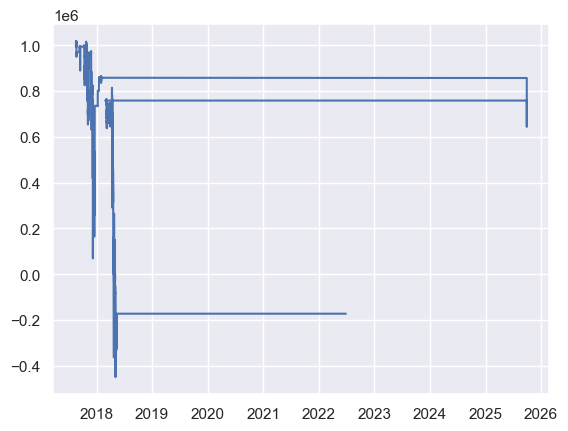

In [20]:
df = pd.DataFrame({
    'Value': portfolio_value,
    'Datetime': pd.to_datetime(train.Datetime)
})

plt.plot(df.Datetime, df.Value);

## <font color='cornflowerblue'> Metrics

In [21]:
metrics = TradingMetrics(portfolio_value, time_frame=5)
metrics.show_metrics()

,Metric,Value
0,Sharpe Ratio,-0.103282
1,Sortino Ratio,-0.149351
2,Max Drawdown,144.12%
3,Calmar Ratio,-6.060458


In [22]:
rsi_indicator = ta.momentum.RSIIndicator(data.Close, window=15)
data['rsi'] = rsi_indicator.rsi()

In [23]:
sma_low = ta.trend.SMAIndicator(data.Close, window=50)
data['sma_low'] = sma_low.sma_indicator()

smi_high = ta.trend.SMAIndicator(data.Close, window=200)
data['sma_high'] = smi_high.sma_indicator()

In [24]:
macd_indicator = ta.trend.MACD(
    close=data.Close,
    window_slow=26,  # standard slow EMA
    window_fast=12,  # standard fast EMA
    window_sign=9    # signal line EMA
)

data['macd'] = macd_indicator.macd()
data['macd_signal'] = macd_indicator.macd_signal()
data['macd_diff'] = macd_indicator.macd_diff()

In [25]:
data['rsi_buy_signal'] = data['rsi'] < 20
data['rsi_sell_signal'] = data['rsi'] > 80

data['sma_buy_signal'] = ((data['sma_low'] > data['sma_high']) & (data['sma_low'].shift(1) <= data['sma_high'].shift(1)))
data['sma_sell_signal'] = ((data['sma_low'] < data['sma_high']) & (data['sma_low'].shift(1) >= data['sma_high'].shift(1)))

data['macd_buy_signal'] = ((data['macd'] > data['macd_signal']) & (data['macd'].shift(1) <= data['macd_signal'].shift(1)))
data['macd_sell_signal'] = ((data['macd'] < data['macd_signal']) & (data['macd'].shift(1) >= data['macd_signal'].shift(1)))

data.head()

,Unnamed: 0,Timestamp,Gmtoffset,Datetime,Open,High,Low,Close,Volume,rsi,...,sma_high,macd,macd_signal,macd_diff,rsi_buy_signal,rsi_sell_signal,sma_buy_signal,sma_sell_signal,macd_buy_signal,macd_sell_signal
0,0,1609770600,0,2021-01-04 14:30:00,133.570007,133.611602,132.389999,132.809997,6624663.0,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,False,False
1,1,1609770900,0,2021-01-04 14:35:00,132.750000,132.750000,131.809997,131.889999,2541553.0,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,False,False
2,2,1609771200,0,2021-01-04 14:40:00,131.500000,132.339996,131.500000,132.059997,2492415.0,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,False,False
3,3,1609771500,0,2021-01-04 14:45:00,132.000000,132.250000,131.899993,132.250000,1859131.0,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,False,False
4,4,1609771800,0,2021-01-04 14:50:00,132.000000,132.018096,131.520004,131.589996,1780105.0,NaN,...,NaN,NaN,NaN,NaN,False,False,False,False,False,False


In [26]:
data['buy_signal'] = (data[['rsi_buy_signal', 'sma_buy_signal', 'macd_buy_signal']].sum(axis=1) >= 2)
data['sell_signal'] = (data[['rsi_sell_signal', 'sma_sell_signal', 'macd_sell_signal']].sum(axis=1) >= 2)

In [27]:
data.buy_signal.sum()
data.sell_signal.sum()

5

In [28]:
data = pd.read_csv('Binance_BTCUSDT_1h.csv').dropna()
data = data.rename(columns={"Date": "Datetime"})
data["Datetime"] = pd.to_datetime(data["Datetime"], errors="coerce", dayfirst=True)
data = data.sort_values(by="Datetime", ascending=True).reset_index(drop=True)
data.head()

/var/folders/60/rl4yk8jj3453bx7hbt074rbc0000gn/T/ipykernel_66508/3479870748.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["Datetime"] = pd.to_datetime(data["Datetime"], errors="coerce", dayfirst=True)


,Unix,Datetime,Symbol,Open,High,Low,Close,Volume BTC,Volume USDT,tradecount
0,1.502940e+12,2017-08-17 04:00:00,BTCUSDT,4261.48,4313.62,4261.32,4308.83,47.181009,202366.138400,171
1,1.502950e+12,2017-08-17 05:00:00,BTCUSDT,4308.83,4328.69,4291.37,4315.32,23.234916,100304.823600,102
2,1.502950e+12,2017-08-17 06:00:00,BTCUSDT,4330.29,4345.45,4309.37,4324.35,7.229691,31282.312670,36
3,1.502950e+12,2017-08-17 07:00:00,BTCUSDT,4316.62,4349.99,4287.41,4349.99,4.443249,19241.058300,25
4,1.502960e+12,2017-08-17 08:00:00,BTCUSDT,4333.32,4377.85,4333.32,4360.69,0.972807,4239.503586,28


In [29]:
train_size = int(len(data) * 0.6)
test_size = int(len(data) * 0.2)

train = data[:train_size]
test = data[train_size:train_size + test_size]
validation = data[train_size + test_size:]

In [30]:
train

,Unix,Datetime,Symbol,Open,High,Low,Close,Volume BTC,Volume USDT,tradecount
0,1.502940e+12,2017-08-17 04:00:00,BTCUSDT,4261.48,4313.62,4261.32,4308.83,47.181009,2.023661e+05,171
1,1.502950e+12,2017-08-17 05:00:00,BTCUSDT,4308.83,4328.69,4291.37,4315.32,23.234916,1.003048e+05,102
2,1.502950e+12,2017-08-17 06:00:00,BTCUSDT,4330.29,4345.45,4309.37,4324.35,7.229691,3.128231e+04,36
3,1.502950e+12,2017-08-17 07:00:00,BTCUSDT,4316.62,4349.99,4287.41,4349.99,4.443249,1.924106e+04,25
4,1.502960e+12,2017-08-17 08:00:00,BTCUSDT,4333.32,4377.85,4333.32,4360.69,0.972807,4.239504e+03,28
...,...,...,...,...,...,...,...,...,...,...
42491,1.658670e+12,2022-07-24 13:00:00,BTCUSDT,22495.59,22597.92,22447.44,22569.34,4050.070190,9.124732e+07,145955
42492,1.658670e+12,2022-07-24 14:00:00,BTCUSDT,22567.75,22800.00,22533.73,22774.30,7379.409680,1.675503e+08,220108
42493,1.658670e+12,2022-07-24 15:00:00,BTCUSDT,22774.30,22911.31,22741.40,22847.08,5505.144190,1.256734e+08,172136
42494,1.658680e+12,2022-07-24 16:00:00,BTCUSDT,22847.08,22880.87,22630.00,22709.01,5631.701210,1.279942e+08,171092


In [31]:
test

,Unix,Datetime,Symbol,Open,High,Low,Close,Volume BTC,Volume USDT,tradecount
42496,1.658690e+12,2022-07-24 18:00:00,BTCUSDT,22772.14,22794.55,22680.00,22712.48,2717.86344,6.178705e+07,115526
42497,1.658690e+12,2022-07-24 19:00:00,BTCUSDT,22712.48,22803.84,22663.44,22700.40,3236.08706,7.357934e+07,128358
42498,1.658690e+12,2022-07-24 20:00:00,BTCUSDT,22699.12,22805.69,22670.21,22718.33,2719.01882,6.178935e+07,111511
42499,1.658700e+12,2022-07-24 21:00:00,BTCUSDT,22718.33,22828.02,22671.41,22808.44,2965.26906,6.751463e+07,115807
42500,1.658700e+12,2022-07-24 22:00:00,BTCUSDT,22806.47,23014.64,22555.27,22657.20,8908.24793,2.033024e+08,256179
...,...,...,...,...,...,...,...,...,...,...
56656,1.709670e+12,2024-03-05 19:00:00,BTCUSDT,63988.37,64244.49,59005.00,61410.98,15733.56404,9.776946e+08,519761
56657,1.709670e+12,2024-03-05 20:00:00,BTCUSDT,61410.98,63158.52,61167.91,61886.32,12043.45143,7.510332e+08,437377
56658,1.709670e+12,2024-03-05 21:00:00,BTCUSDT,61886.32,63979.99,61870.00,63264.24,7553.16632,4.777831e+08,275823
56659,1.709680e+12,2024-03-05 22:00:00,BTCUSDT,63264.23,63574.26,62471.62,63397.99,3203.21560,2.020599e+08,152339


In [32]:
validation

,Unix,Datetime,Symbol,Open,High,Low,Close,Volume BTC,Volume USDT,tradecount
56661,1.709680e+12,2024-03-06 00:00:00,BTCUSDT,63724.01,64146.45,63390.00,63429.18,3066.234630,1.955341e+08,101808
56662,1.709690e+12,2024-03-06 01:00:00,BTCUSDT,63429.17,63780.06,63088.25,63108.60,2268.115400,1.438297e+08,85488
56663,1.709690e+12,2024-03-06 02:00:00,BTCUSDT,63108.60,63500.00,62779.14,62795.00,2225.549430,1.406547e+08,93618
56664,1.709690e+12,2024-03-06 03:00:00,BTCUSDT,62795.00,63373.14,62785.97,63263.21,1935.987460,1.222204e+08,95512
56665,1.709700e+12,2024-03-06 04:00:00,BTCUSDT,63263.22,64611.97,63263.21,64607.98,2668.360230,1.704323e+08,179798
...,...,...,...,...,...,...,...,...,...,...
70822,1.518180e+12,NaT,BTCUSDT,8279.78,8450.12,8268.70,8390.04,1745.803265,1.460150e+07,17754
70823,1.518180e+12,NaT,BTCUSDT,8215.85,8314.99,8212.77,8269.11,1059.131674,8.748633e+06,12017
70824,1.518180e+12,NaT,BTCUSDT,8301.01,8395.00,8201.95,8219.98,1275.866926,1.059433e+07,13739
70825,1.518170e+12,NaT,BTCUSDT,8179.80,8339.00,8166.00,8301.01,1252.617892,1.035459e+07,12063


In [33]:
test['Datetime'].value_counts()

Datetime
2022-07-24 18:00:00    1
2023-08-22 12:00:00    1
2023-08-22 01:00:00    1
2023-08-22 02:00:00    1
2023-08-22 03:00:00    1
                      ..
2023-02-06 14:00:00    1
2023-02-06 15:00:00    1
2023-02-06 16:00:00    1
2023-02-06 17:00:00    1
2024-03-05 23:00:00    1
Name: count, Length: 14165, dtype: int64

In [34]:
validation['Datetime'].value_counts()

Datetime
2025-09-29 00:00:00    597
2025-03-05 23:00:00      2
2025-03-06 06:00:00      2
2025-03-06 05:00:00      2
2025-03-06 04:00:00      2
                      ... 
2024-09-02 23:00:00      1
2024-09-03 00:00:00      1
2024-09-03 01:00:00      1
2024-09-03 02:00:00      1
2024-12-02 06:00:00      1
Name: count, Length: 13021, dtype: int64

In [35]:
validation[validation['Datetime'] == '2025-03-05 23:00:00']

,Unix,Datetime,Symbol,Open,High,Low,Close,Volume BTC,Volume USDT,tradecount
65787,1.741220e+12,2025-03-05 23:00:00,BTCUSDT,90449.47,91000.0,90296.04,90606.01,775.34311,70292755.64,179383
65788,1.741216e+15,2025-03-05 23:00:00,BTCUSDT,90449.47,91000.0,90296.04,90606.01,775.34311,70292755.64,179383


In [36]:
data

,Unix,Datetime,Symbol,Open,High,Low,Close,Volume BTC,Volume USDT,tradecount
0,1.502940e+12,2017-08-17 04:00:00,BTCUSDT,4261.48,4313.62,4261.32,4308.83,47.181009,2.023661e+05,171
1,1.502950e+12,2017-08-17 05:00:00,BTCUSDT,4308.83,4328.69,4291.37,4315.32,23.234916,1.003048e+05,102
2,1.502950e+12,2017-08-17 06:00:00,BTCUSDT,4330.29,4345.45,4309.37,4324.35,7.229691,3.128231e+04,36
3,1.502950e+12,2017-08-17 07:00:00,BTCUSDT,4316.62,4349.99,4287.41,4349.99,4.443249,1.924106e+04,25
4,1.502960e+12,2017-08-17 08:00:00,BTCUSDT,4333.32,4377.85,4333.32,4360.69,0.972807,4.239504e+03,28
...,...,...,...,...,...,...,...,...,...,...
70822,1.518180e+12,NaT,BTCUSDT,8279.78,8450.12,8268.70,8390.04,1745.803265,1.460150e+07,17754
70823,1.518180e+12,NaT,BTCUSDT,8215.85,8314.99,8212.77,8269.11,1059.131674,8.748633e+06,12017
70824,1.518180e+12,NaT,BTCUSDT,8301.01,8395.00,8201.95,8219.98,1275.866926,1.059433e+07,13739
70825,1.518170e+12,NaT,BTCUSDT,8179.80,8339.00,8166.00,8301.01,1252.617892,1.035459e+07,12063


In [37]:
data = pd.read_csv('Binance_BTCUSDT_1h.csv').dropna()
data

,Unix,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USDT,tradecount
0,1.758580e+12,22/09/25 23:00,BTCUSDT,112643.25,112739.14,112592.20,112650.99,135.310950,1.524494e+07,34083
1,1.758580e+12,22/09/25 22:00,BTCUSDT,112969.99,112970.00,112594.33,112643.25,289.607150,3.264691e+07,42836
2,1.758570e+12,22/09/25 21:00,BTCUSDT,112781.87,112970.00,112602.79,112969.99,293.311560,3.307493e+07,42931
3,1.758570e+12,22/09/25 20:00,BTCUSDT,112122.90,112977.41,111975.28,112781.88,596.840050,6.707508e+07,93553
4,1.758570e+12,22/09/25 19:00,BTCUSDT,112429.12,112600.87,111936.40,112122.90,1307.373650,1.467768e+08,126232
...,...,...,...,...,...,...,...,...,...,...
70822,1.502960e+12,17/08/17 8:00,BTCUSDT,4333.32,4377.85,4333.32,4360.69,0.972807,4.239504e+03,28
70823,1.502950e+12,17/08/17 7:00,BTCUSDT,4316.62,4349.99,4287.41,4349.99,4.443249,1.924106e+04,25
70824,1.502950e+12,17/08/17 6:00,BTCUSDT,4330.29,4345.45,4309.37,4324.35,7.229691,3.128231e+04,36
70825,1.502950e+12,17/08/17 5:00,BTCUSDT,4308.83,4328.69,4291.37,4315.32,23.234916,1.003048e+05,102


In [38]:
data = pd.read_csv('Binance_BTCUSDT_1h.csv').dropna()
data = data.rename(columns={"Date": "Datetime"})
data["Datetime"] = pd.to_datetime(data["Datetime"], errors="coerce", dayfirst=True)
data

/var/folders/60/rl4yk8jj3453bx7hbt074rbc0000gn/T/ipykernel_66508/154969912.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["Datetime"] = pd.to_datetime(data["Datetime"], errors="coerce", dayfirst=True)


,Unix,Datetime,Symbol,Open,High,Low,Close,Volume BTC,Volume USDT,tradecount
0,1.758580e+12,2025-09-22 23:00:00,BTCUSDT,112643.25,112739.14,112592.20,112650.99,135.310950,1.524494e+07,34083
1,1.758580e+12,2025-09-22 22:00:00,BTCUSDT,112969.99,112970.00,112594.33,112643.25,289.607150,3.264691e+07,42836
2,1.758570e+12,2025-09-22 21:00:00,BTCUSDT,112781.87,112970.00,112602.79,112969.99,293.311560,3.307493e+07,42931
3,1.758570e+12,2025-09-22 20:00:00,BTCUSDT,112122.90,112977.41,111975.28,112781.88,596.840050,6.707508e+07,93553
4,1.758570e+12,2025-09-22 19:00:00,BTCUSDT,112429.12,112600.87,111936.40,112122.90,1307.373650,1.467768e+08,126232
...,...,...,...,...,...,...,...,...,...,...
70822,1.502960e+12,2017-08-17 08:00:00,BTCUSDT,4333.32,4377.85,4333.32,4360.69,0.972807,4.239504e+03,28
70823,1.502950e+12,2017-08-17 07:00:00,BTCUSDT,4316.62,4349.99,4287.41,4349.99,4.443249,1.924106e+04,25
70824,1.502950e+12,2017-08-17 06:00:00,BTCUSDT,4330.29,4345.45,4309.37,4324.35,7.229691,3.128231e+04,36
70825,1.502950e+12,2017-08-17 05:00:00,BTCUSDT,4308.83,4328.69,4291.37,4315.32,23.234916,1.003048e+05,102


In [39]:
data = data.iloc[::-1]
data

,Unix,Datetime,Symbol,Open,High,Low,Close,Volume BTC,Volume USDT,tradecount
70826,1.502940e+12,2017-08-17 04:00:00,BTCUSDT,4261.48,4313.62,4261.32,4308.83,47.181009,2.023661e+05,171
70825,1.502950e+12,2017-08-17 05:00:00,BTCUSDT,4308.83,4328.69,4291.37,4315.32,23.234916,1.003048e+05,102
70824,1.502950e+12,2017-08-17 06:00:00,BTCUSDT,4330.29,4345.45,4309.37,4324.35,7.229691,3.128231e+04,36
70823,1.502950e+12,2017-08-17 07:00:00,BTCUSDT,4316.62,4349.99,4287.41,4349.99,4.443249,1.924106e+04,25
70822,1.502960e+12,2017-08-17 08:00:00,BTCUSDT,4333.32,4377.85,4333.32,4360.69,0.972807,4.239504e+03,28
...,...,...,...,...,...,...,...,...,...,...
4,1.758570e+12,2025-09-22 19:00:00,BTCUSDT,112429.12,112600.87,111936.40,112122.90,1307.373650,1.467768e+08,126232
3,1.758570e+12,2025-09-22 20:00:00,BTCUSDT,112122.90,112977.41,111975.28,112781.88,596.840050,6.707508e+07,93553
2,1.758570e+12,2025-09-22 21:00:00,BTCUSDT,112781.87,112970.00,112602.79,112969.99,293.311560,3.307493e+07,42931
1,1.758580e+12,2025-09-22 22:00:00,BTCUSDT,112969.99,112970.00,112594.33,112643.25,289.607150,3.264691e+07,42836
